# Supervised Learning 

In [1]:
import seaborn as sns 
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, load_boston, load_wine
from scipy.stats import randint, uniform
import pandas as pd 
from os import makedirs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
sns.set()

In [2]:
def evaluate(_estimator: BaseEstimator, _X_train, _X_test, _y_train, _y_test):
    _estimator.fit(_X_train, _y_train.values.ravel())
    y_hat = _estimator.predict(_X_test)
    print(accuracy_score(_y_test, _estimator.predict(_X_test), normalize=True))

In [3]:
def data_breastcancer(_args):
    raw = load_breast_cancer()
    X = pd.DataFrame(raw.data, columns=raw.feature_names)
    y = pd.Categorical.from_codes(raw.target, raw.target_names)
    y = pd.get_dummies(y, drop_first=True)
    data_splits = train_test_split(X, y, test_size=_args['test_size'], random_state=_args['seed'])
    _args["num_features"] = X.shape[1]+1
    return data_splits

def data_census(_args):
    raw = pd.read_csv('data/adult.data.csv', header=0)
    X = pd.DataFrame(raw, columns=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country'])
    #### https://yanhan.github.io/posts/2017-02-15-analysis-of-the-adult-data-set-from-uci-machine-learning-repository.ipynb.html
    X['age'] = X['age'].astype(float)
    X['fnlwgt'] = X['fnlwgt'].astype(float)
    X['education-num'] = X['education-num'].astype(float)
    X['hours-per-week'] = X['hours-per-week'].astype(float)
    X['capital-gain'] = X['capital-gain'].astype(float)
    X['capital-loss'] = X['capital-loss'].astype(float)
    X = X.drop(["workclass", "education", "marital-status", "occupation", "relationship","race", "sex", "native-country"], axis=1)
    # X = pd.get_dummies(X, columns=["workclass", "education", "marital-status", "occupation", "relationship","race", "sex", "native-country"])
    raw['label'] = raw['label'].transform(lambda x: 0 if x == '<=50K' else 1)
    # 0=<=50k>, 1=>50k
    y = pd.Categorical.from_codes(raw['label'], [0, 1])
    y = pd.get_dummies(y, drop_first=True)
    data_splits = train_test_split(X, pd.get_dummies(y), test_size=_args['test_size'], random_state=_args['seed'])
    _args["num_features"] = X.shape[1]+1
    return data_splits

In [4]:
args = {
    "test_size": 0.25,
    "seed": 1,
}

In [5]:
def random_search(_estimator: BaseEstimator, _X_train, _X_test, _y_train, _y_test, _parameters, _n_iter=100, _n_jobs=None, _cv=5, _verbose=1):
    model = RandomizedSearchCV(
            estimator=_estimator,
            # scoring=self.scorers,
            # refit=config['score_type'],
            param_distributions=_parameters, 
            random_state=args["seed"], 
            n_iter=_n_iter, 
            cv=_cv, 
            verbose=_verbose, 
            n_jobs=_n_jobs
        ).fit(_X_train, _y_train)
    print('model_random', model.best_params_)
    evaluate(model, _X_train, _X_test, _y_train, _y_test)
    return model

In [6]:
def grid_search(_estimator: BaseEstimator, _X_train, _X_test, _y_train, _y_test, _parameters, _n_jobs=None, _cv=5, _verbose=1):
    model = GridSearchCV(
            estimator=_estimator, 
            param_grid=_parameters, 
            cv=_cv, 
            n_jobs=_n_jobs,
            verbose=_verbose
        ).fit(_X_train, _y_train.values.ravel())
    print('model_grid', model.best_params_)
    evaluate(model, _X_train, _X_test, _y_train, _y_test)
    return model

In [7]:
#### CITE: https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
def plot_validation_curve(
    _name, 
    _estimator, 
    _X,
    _y, 
    _data_id,
    _model_complexity_parameter,
    _model_complexity_parameter_range,
    _cv=5, 
    _n_jobs=None,
    _ylim=(0.7, 1.01),
):
    text = {'fontsize': 15, 'fontweight': 'bold'}
    train_scores, test_scores = validation_curve(
        _estimator, 
        _X, 
        _y, 
        param_name=_model_complexity_parameter, 
        param_range=_model_complexity_parameter_range,
        scoring="accuracy", 
        n_jobs=_n_jobs, 
        cv=_cv
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    makedirs(f'plots_{_data_id}/{_name}', exist_ok=True)

    plt.title(f"Validation Curve: {_name}", text)
    plt.xlabel(_model_complexity_parameter, text)
    plt.ylabel("Accuracy Score", text)
    plt.ylim(_ylim)
    lw = 2
    plt.plot(_model_complexity_parameter_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(_model_complexity_parameter_range, 
                     train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.plot(_model_complexity_parameter_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(_model_complexity_parameter_range, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")

    plt.savefig(f'plots_{_data_id}/{_name}/validation_{_model_complexity_parameter}.png')
    plt.show()
#### END CITE

In [8]:
#### CITE: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    _name, 
    _estimator, 
    _X, 
    _y, 
    _data_id,
    _cv=5, 
    _n_jobs=None, 
    _ylim=(0.7, 1.01), 
    _train_sizes=np.linspace(.1, 1.0, 20)
):
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(
            _estimator, 
            _X, 
            _y, 
            scoring="accuracy", 
            cv=_cv, 
            n_jobs=_n_jobs, 
            train_sizes=_train_sizes, 
            return_times=True
        )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot 
    text = {'fontsize': 15, 'fontweight': 'bold'}
    plt.title(f"Learning Curve: {_name}", text)
    if _ylim is not None:
        plt.ylim(_ylim)
    plt.xlabel("Training examples", text)
    plt.ylabel("Accuracy Score", text)
    makedirs(f'plots_{_data_id}/{_name}', exist_ok=True)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.savefig(f'plots_{_data_id}/{_name}/learning_curve.png')
    plt.show()

    # Plot n_samples vs fit_times
    plt.grid()
    plt.plot(train_sizes, fit_times_mean, 'o-')
    plt.fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    plt.xlabel("Training examples", text)
    plt.ylabel("Fit Time (seconds)", text)
    plt.title(f"Model Scalability: {_name}", text)
    plt.savefig(f'plots_{_data_id}/{_name}/scalability.png')
    plt.show()

    # Plot fit_time vs score
    plt.grid()
    plt.plot(fit_times_mean, test_scores_mean, 'o-')
    plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    plt.xlabel("Fit Time (seconds)", text)
    plt.ylabel("Accuracy Score", text)
    plt.title(f"Model Performance {_name}", text)
    plt.savefig(f'plots_{_data_id}/{_name}/performance.png')
    plt.show()
#### END CITE

# Decision Tree

breastcancer
0.951048951048951
census
0.838471932195062


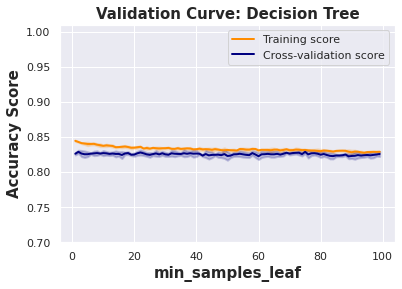

In [26]:
for data_id in ['breastcancer', 'census']:
    print(data_id)
    if data_id == 'breastcancer':
        X_train, X_test, y_train, y_test = data_breastcancer(args)
        # _ = random_search(DecisionTreeClassifier(random_state=args['seed']), X_train, X_test, y_train, y_test, {
        #   "max_depth": randint(1, 20),
        #   "max_features": randint(1, args['num_features']),
        #   "min_samples_leaf": randint(1, 20),
        #   "criterion": ["entropy"]
        # })
        # # model_random {'criterion': 'entropy', 'max_depth': 11, 'max_features': 28, 'min_samples_leaf': 5}
        # # 0.951048951048951

        # _ = grid_search(DecisionTreeClassifier(random_state=args['seed']), X_train, X_test, y_train, y_test, {
        #   "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        #   "max_features": [3, 5, 10, 15, 18, 23, 25, 26, 27, 28, 29, 30],
        #   "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15],
        #   "criterion": ["entropy"]
        # })
        # model_grid {'criterion': 'entropy', 'max_depth': 4, 'max_features': 18, 'min_samples_leaf': 3}
        # 0.916083916083916

        # 0.951048951048951
        kwargs = {
            "max_depth": 11,
            "max_features": 28,
            "min_samples_leaf": 5,
            "criterion": "entropy",
            "random_state": args['seed']
        }
        evaluate(DecisionTreeClassifier(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, _cv=5)
        
        plot_validation_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'max_depth', np.arange(1, 10), _cv=5)
        plot_validation_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'max_features', np.arange(1, args['num_features']), _cv=5)
        plot_validation_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'min_samples_leaf', np.arange(1, 30), _cv=5)
            
    elif data_id == 'census':
        X_train, X_test, y_train, y_test = data_census(args)
        # _ = random_search(DecisionTreeClassifier(random_state=args['seed']), X_train, X_test, y_train, y_test, {
        #   "max_depth": randint(1, 100),
        #   "max_features": randint(1, args['num_features']),
        #   "min_samples_leaf": randint(1, 100),
        #   "criterion": ["entropy"]
        # })

        kwargs = {
            "max_depth": 11,
            "max_features": 3,
            "min_samples_leaf": 5,
            "criterion": "entropy",
            "random_state": args['seed']
        }
        evaluate(DecisionTreeClassifier(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, _cv=5)

        plot_validation_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'max_depth', np.arange(1, 30), _cv=5)
        plot_validation_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'max_features', np.arange(1, args['num_features']), _cv=5)
        plot_validation_curve('Decision Tree', DecisionTreeClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'min_samples_leaf', np.arange(1, 100), _cv=5)




# Boosting

In [31]:
for data_id in ['census']:
    print(data_id)
    if data_id == 'breastcancer':
        X_train, X_test, y_train, y_test = data_breastcancer(args)
        # _ = random_search(AdaBoostClassifier(random_state=args['seed']), X_train, X_test, y_train, y_test, {
        #     "n_estimators": [50],
        #     "learning_rate": [1.0]
        # })
        # # model_random {'n_estimators': 50, 'learning_rate': 1.0}
        # # 0.958041958041958

        # _ = grid_search(AdaBoostClassifier(random_state=args['seed']), X_train, X_test, y_train, y_test, {
        #     "n_estimators": [25, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 75, 100],
        #     "learning_rate": [0.001, 0.01, 0.1, 0.75, 1.0, 1.25]
        # })
        # # model_grid {'learning_rate': 0.75, 'n_estimators': 54}
        # # 0.958041958041958

        # 0.958041958041958
        kwargs = {
            "n_estimators": 50,
            "learning_rate": 1.0,
            'random_state': args['seed']
        }

        evaluate(AdaBoostClassifier(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('Boosting', AdaBoostClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('Boosting', AdaBoostClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'learning_rate', np.logspace(-6, -1, 12))
        plot_validation_curve('Boosting', AdaBoostClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'n_estimators', np.arange(1, 100, 10))


    elif data_id == 'census':

        X_train, X_test, y_train, y_test = data_census(args)

        kwargs = {
            "n_estimators": 50,
            "learning_rate": 0.8,
            'random_state': args['seed']
        }

        evaluate(AdaBoostClassifier(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('Boosting', AdaBoostClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('Boosting', AdaBoostClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'learning_rate', np.logspace(-6, 1, 12))
        plot_validation_curve('Boosting', AdaBoostClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'n_estimators', np.arange(1, 200, 50))






census


KeyboardInterrupt: KeyboardInterrupt: 

# KNN

breastcancer
0.9440559440559441
census
0.8056749785038693


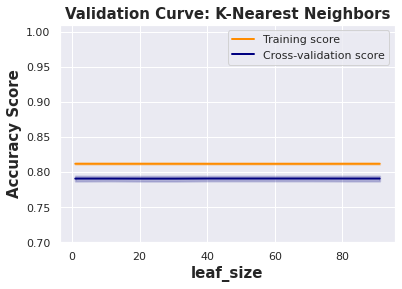

In [33]:
for data_id in ['breastcancer', 'census']:
  print(data_id)
  if data_id == 'breastcancer':
    X_train, X_test, y_train, y_test = data_breastcancer(args)
    # _ = random_search(KNeighborsClassifier(), X_train, y_train.values.ravel(), {
    #     "n_neighbors": randint(1, 15),
    #     "leaf_size": randint(1, 30),
    #     "metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    #     "weights": ["uniform", "distance"],
    #     "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
    # })
    # # model_random {'algorithm': 'auto', 'leaf_size': 26, 'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}
    # # 0.9440559440559441

    # _ = grid_search(KNeighborsClassifier(), X_train, y_train.values.ravel(), {
    #     "n_neighbors": [6, 8, 10, 12], # range(1, 15, 3),
    #     "leaf_size": [20, 25, 30], # range(1, 30, 5),
    #     "metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    #     "weights": ["uniform", "distance"],
    #     "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
    # })
    # # model_grid {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}
    # # 0.9440559440559441

    # 0.9440559440559441
    kwargs = {
      'n_neighbors': 8,
      "leaf_size": 20,
      "metric": 'manhattan',
      "weights": "uniform",
      "algorithm": 'auto',
      'n_jobs': None
    }
    evaluate(KNeighborsClassifier(**kwargs), X_train, X_test, y_train, y_test)
    plot_learning_curve('K-Nearest Neighbors', KNeighborsClassifier(**kwargs), 
      X_train, y_train.values.ravel(), data_id)

    plot_validation_curve('K-Nearest Neighbors', KNeighborsClassifier(**kwargs), 
      X_train, y_train.values.ravel(), data_id, 'n_neighbors', np.arange(1, 20, 1))
    # plot_validation_curve('K-Nearest Neighbors', KNeighborsClassifier(**kwargs), 
    #   X_train, y_train.values.ravel(), data_id, 'leaf_size', np.arange(1, 100, 10))


  elif data_id == 'census':
    X_train, X_test, y_train, y_test = data_census(args)

    kwargs = {
      'n_neighbors': 8,
      "leaf_size": 20,
      "metric": 'manhattan',
      "weights": "uniform",
      "algorithm": 'auto',
      'n_jobs': None
    }
    evaluate(KNeighborsClassifier(**kwargs), X_train, X_test, y_train, y_test)
    plot_learning_curve('K-Nearest Neighbors', KNeighborsClassifier(**kwargs), 
    X_train, y_train.values.ravel(), data_id)

    plot_validation_curve('K-Nearest Neighbors', KNeighborsClassifier(**kwargs), 
    X_train, y_train.values.ravel(), data_id, 'n_neighbors', np.arange(1, 100, 10))
    plot_validation_curve('K-Nearest Neighbors', KNeighborsClassifier(**kwargs), 
    X_train, y_train.values.ravel(), data_id, 'leaf_size', np.arange(1, 100, 10))





# Neural Network

breastcancer
0.9300699300699301
census
0.8033411128853949


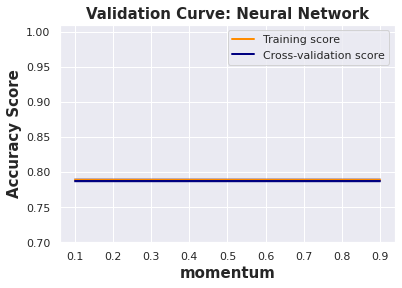

In [34]:
for data_id in ['breastcancer', 'census']:
    print(data_id)
    if data_id == 'breastcancer':
        X_train, X_test, y_train, y_test = data_breastcancer(args)
        # _ = random_search(MLPClassifier(random_state=args['seed'], early_stopping=True), X_train, y_train.values.ravel(), {
        #     'hidden_layer_sizes': [(10,), (10, 10, 10), (5, 5, 5, 5), (100,), (50, 50, 50), (50, 100, 50)],  # [x for x in product((10,20,30,40,50,100), repeat=3)]
        #     'alpha': [0.0001, 0.001, 0.01, 0.1],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
        #     'batch_size': [10, 50, 100],
        #     'momentum': np.arange(0.1, 1.0, 0.1),
        #     'activation': ['tanh', 'relu'], 
        #     'solver': ['lbfgs', 'sgd', 'adam'],
        #     'learning_rate': ['constant', 'invscaling', 'adaptive'], 
        # }, _n_iter=100)
        # model_random {'solver': 'lbfgs', 'momentum': 0.8, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'batch_size': 100, 'alpha': 0.01, 'activation': 'relu'}
        # 0.91608391608391

        # _ = grid_search(MLPClassifier(random_state=args['seed'], early_stopping=True), X_train, y_train.values.ravel(), {
        #     'hidden_layer_sizes': [(50, 50, 50)],  # [x for x in product((10,20,30,40,50,100), repeat=3)]
        #     'alpha': [0.001, 0.01, 0.1],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
        #     'batch_size': [200, 300],
        #     'momentum': np.arange(0.1, 1.0, 0.1),
        #     'activation': ['tanh', 'relu'], 
        #     'solver': ['lbfgs', 'sgd', 'adam'],
        #     'learning_rate': ['adaptive'], 
        # })
        # # model_grid {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
        # # 0.9300699300699301

        # 0.9300699300699301
        kwargs = {
            'hidden_layer_sizes': (50, 50, 50),
            'alpha': 0.1,
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'random_state': args['seed'],
            'early_stopping': True
        }
        evaluate(MLPClassifier(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('Neural Network', MLPClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('Neural Network', MLPClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'alpha', np.logspace(-6, -1, 12))
        plot_validation_curve('Neural Network', MLPClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'momentum', np.arange(0.1, 1.0, 0.1))

    elif data_id == 'census':
        X_train, X_test, y_train, y_test = data_census(args)

        kwargs = {
            'hidden_layer_sizes': (50, 50, 50),
            'alpha': 0.1,
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'random_state': args['seed'],
            'early_stopping': True
        }
        evaluate(MLPClassifier(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('Neural Network', MLPClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('Neural Network', MLPClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'alpha', np.logspace(-6, -1, 12)) # 
        plot_validation_curve('Neural Network', MLPClassifier(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'momentum', np.arange(0.1, 1.0, 0.1))



# SVM (Linear Kernel)

breastcancer
0.9370629370629371
census


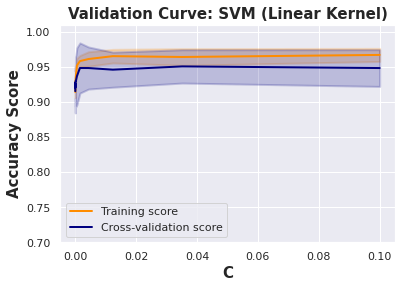

In [17]:
for data_id in ['breastcancer', 'census']:
    print(data_id)
    if data_id == 'breastcancer':

        X_train, X_test, y_train, y_test = data_breastcancer(args)

        # _ = random_search(SVC(random_state=args['seed'], kernel='linear'), X_train, X_test, y_train, y_test, {
        #     'C': [0.0001, 0.00001, 0.001],
        # })

        # _ = grid_search(SVC(random_state=args['seed'], kernel='linear'), X_train, X_test, y_train, y_test, {
        #     'C': [0.1, 1., 10., 100., 1000.],
        # })

        # 0.9370629370629371
        kwargs = {
            'C': 0.01,
            'kernel': 'linear',
            'random_state': args['seed']
        }
        evaluate(SVC(**kwargs), X_train, X_test, y_train, y_test )
        plot_learning_curve('SVM (Linear Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('SVM (Linear Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'C', np.logspace(-6, -1, 12))


    elif data_id == 'census':
        X_train, X_test, y_train, y_test = data_census(args)

        kwargs = {
            'C': 0.01,
            'kernel': 'linear',
            'random_state': args['seed']
        }
        evaluate(SVC(**kwargs), X_train, X_test, y_train, y_test )
        plot_learning_curve('SVM (Linear Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('SVM (Linear Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'C', np.logspace(-6, -1, 12))

# SVM (Poly Kernel)

In [18]:
for data_id in ['breastcancer', 'census']:
    print(data_id)
    if data_id == 'breastcancer':

        X_train, X_test, y_train, y_test = data_breastcancer(args)

        # _ = random_search(SVC(random_state=args['seed'], kernel='poly'), X_train, X_test, y_train, y_test, {
        #     'C': [0.0001, 0.00001, 0.001],
        #     'gamma': [0.0001, 0.00001, 0.001]
        # })

        # _ = grid_search(SVC(random_state=args['seed'], kernel='poly'), X_train, X_test, y_train, y_test, {
        #     'C': [0.001],
        #     'gamma': [0.001]
        # })

        # 0.951048951048951
        kwargs = {
            # 'C': 1.0,
            'gamma': 'auto',
            'kernel': 'poly', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
            'random_state': args['seed']
        }
        evaluate(SVC(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('SVM (Poly Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('SVM (Poly Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'gamma', np.logspace(-6, -1, 12))

    elif data_id == 'census':
        X_train, X_test, y_train, y_test = data_census(args)

        kwargs = {
            'C': 0.001,
            'gamma': 0.001,
            'kernel': 'poly', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
            'random_state': args['seed']
        }
        evaluate(SVC(**kwargs), X_train, X_test, y_train, y_test)
        plot_learning_curve('SVM (Poly Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id)

        plot_validation_curve('SVM (Poly Kernel)', SVC(**kwargs), 
            X_train, y_train.values.ravel(), data_id, 'gamma', np.logspace(-6, -1, 12))

breastcancer
